In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, pickle, pyemma as py, sys, os
import pandas as pd
import seaborn as sns 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
%matplotlib inline
from temp_tf_load import *
sys.path.append('../')
from hde import HDE, analysis
lag_time = 10
import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)
print(py.__version__)



/software/python-3.7.0-el7-x86_64/bin/python3.7


ModuleNotFoundError: No module named 'pyemma'

In [7]:
# load thermo and pairwise distance features seperately
# only pwd features are used to train the model, thermo are for plotting

trim_length = 1000   #uses this many trajs from full list
chunk_size = 400    #takes this large of a bite from the middle of alreadhy chunked data


#thermo_features = np.load('/home/mikejones/scratch-midway2/srv/dna_data/thermo-2831-1000-10.npy')
pwd_features_trimmed = np.load('/home/mikejones/scratch-midway2/srv/dna_data/pwdr-2831-1000-190.npy')[:trim_length]
#pwd_features = [item[int((trim_length - chunk_size) / 2) : int((trim_length + chunk_size) / 2), :] for item in pwd_features_trimmed]
pwd_features = np.load('/home/mikejones/scratch-midway2/srv/dna_data/pwdr-all_t-1000-5000-190.npy')[:1000]

scaler = pre.MinMaxScaler(feature_range=(-1, 1))

#scaler.fit(np.concatenate(thermo_features))
#thermo_features_s = [scaler.transform(item) for item in thermo_features]

scaler.fit(np.concatenate(pwd_features))
pwd_features_s = [scaler.transform(item) for item in pwd_features]

print(np.shape(pwd_features))


(1000, 5000, 190)


(5000000, 190)
0.9526292


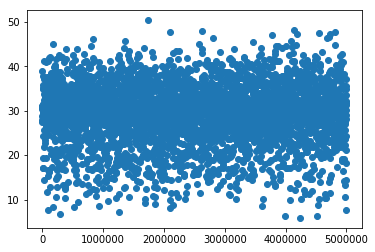

In [39]:
## code to find max end to end distance between oligomers

conc_pwdr = np.concatenate(pwd_features)
print (np.shape(conc_pwdr))

end_cols_1 = 1 / conc_pwdr[:, 136]
end_cols_2 = 1 / conc_pwdr[:, 181]

cnt = 0 
for i in end_cols_1:
    if i < 41 and i > 14:
        cnt += 1

print(cnt/len(end_cols_1))

ends_1.append(1 / np.std(end_cols_1))
ends_2.append(1 / np.std(end_cols_2))


fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, len(end_cols_1), len(end_cols_1))
ax.scatter(x[::1000], end_cols_1[::1000])
#ax.scatter(x, end_cols_2)

plt.show()

## kernel tICA

In [3]:
from temp_ktica import *

In [4]:
# find landmarks, this may take a while.  We use 5000 landmarks in our paper, but it 
# takes very long time to do clustering, so here we use 2000 instead
# try using 1000 instead 

from sklearn.cluster import KMeans
n_landmarks = 400
kmeans = KMeans(init='k-means++', n_clusters=n_landmarks, n_init=10)
kmeans.fit(np.concatenate(pwd_features_s)[::50])


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=400, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [5]:

# take longer than previous cell
temp_dataset = np.concatenate(pwd_features_s)
temp_landmarks = kmeans.cluster_centers_
for sigma in [2.0]:    #  # best sigma for scaled pairwise distances with 5000 landmarks
    ktica = Kernel_tica(3, lag_time=10, gamma=1./(2 * sigma ** 2), n_components_nystroem=len(temp_landmarks), 
                       landmarks = temp_landmarks)
    ktica_coords = ktica.fit_transform([temp_dataset])[0]
    print(sigma, ktica._tica.timescales[:5])
    ktica_timescales = ktica._tica.timescales[:3]



using landmarks


2.0 [556.11934855 193.95937733 116.10733044  86.29322303  33.83891907]


In [6]:


print (np.shape(ktica_coords))
print (ktica_timescales)

#np.save('/home/mikejones/scratch-midway2/srv/ktica_coords/unchunk_300-t_1000-c_500-s.npy', ktica_coords)



(1500000, 3)
[556.11934855 193.95937733 116.10733044]


In [7]:
# these are precomputed ktica coordinates and timescales
#ktica_coords = np.load('/home/mikejones/scratch-midway2/srv/ktica_coords/chunk_500-t_1000-c_50-s.npy')
# ktica_coords = np.load('/home/mikejones/scratch-midway2/srv/ktica_coords/unchunk_100-t_1000-c_50-s.npy')
# ktica_timescales = np.load('/home/kengyangyao/data/hde_paper_results/adp_ktica_timescales.npy')

## HDE

In [8]:
skip = 1
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

n_sm = 6 

hde = HDE(190, n_components=n_sm, lag_time=lag_time // skip, dropout_rate=0, batch_size=500000, n_epochs=10, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])


In [9]:
# hde.r_degree = 10    # pre-training, to speed up discovery of first few slowest modes
# hde.batch_size = 200000
# hde.n_epochs = 50
# hde.fit(pairwise_dis_s)
# hde._recompile = True
# hde.r_degree = 5
# hde.fit(pairwise_dis_s)
# hde.batch_size = 500000
# hde._recompile = True
# hde.r_degree = 2
# hde.n_epochs = 100
# hde.fit(pairwise_dis_s)

In [10]:
hde.r_degree = 2
hde.n_epochs = 100
hde.fit(np.concatenate(pwd_features_s))


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1199992 samples, validate on 299998 samples
Epoch 1/100
1199992/1199992 [==============================] - 15s 13us/step - loss: -2.0085 - val_loss: -3.2793
Epoch 2/100
1199992/1199992 [==============================] - 10s 9us/step - loss: -3.5277 - val_loss: -3.9913
Epoch 3/100
1199992/1199992 [==============================] - 10s 9us/step - loss: -4.2677 - val_loss: -4.6567
Epoch 4/100
1199992/1199992 [==============================] - 11s 9us/step - loss: -4.7573 - val_loss: -4.9484
Epoch 5/100
1199992/1199992 [==============================] - 11s 9us/step - loss: -5.0177 - val_loss: -5.2515
Epoch 6/100
1199992/1199992 [==============================] - 10s 8us/step - loss: -5.3447 - val_loss: -5.5210
Epoch 7/100
1199992/1199992 [==============================] - 11s 9us/step - loss: -5.5860 - val_loss: -5.6804
Epoch 8/100
11999

HDE(activation=None, batch_normalization=True, batch_size=500000,
    callbacks=[<keras.callbacks.EarlyStopping object at 0x7fc0342ae160>],
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=190,
    l2_regularization=0.0, lag_time=10, latent_space_noise=0,
    learning_rate=0.01, n_components=6, n_epochs=100, validation_split=0.2,
    verbose=True)

In [11]:

hde_coords = [hde.transform(item) for item in pwd_features_s]
#np.save('/home/mikejones/scratch-midway2/srv/hde_coords/unchunk_300-t_190-f', ktica_coords)
hde_timescales = hde.timescales_
print(hde_timescales)


[1443.7935897   934.54856453  761.82284971  424.46509026  228.69969099
  132.25566606]


In [42]:
## make pandas data frame
## add ktica coords to df

skip = 1000    #num coords to skip on plot
num_bp = 10

print (np.shape(hde_coords))
print (np.shape(pwd_features_s))

hde_coords_conc = np.concatenate(hde_coords)[::skip]
pwd_features_conc = np.concatenate(pwd_features_s)[::skip]

index_size = len(hde_coords_conc[:, 0])

print (np.shape(hde_coords_conc))
print (np.shape(pwd_features_conc))


hde_col_list = ['1st_EF', '2nd_EF', '3rd_EF', '4th_EF', '5th_EF', '6th_EF', '7th_EF']
df = pd.DataFrame(data    = hde_coords_conc, 
                  columns = hde_col_list[:n_sm],
                  index   = np.linspace(1, index_size, index_size))

#dict shows which indices need to be averaged in order to form their corresponding features
bp_match_dict  =  {'inter_ends':[9, 90],
                   'inter_cores':[45, 54],
                   'inter_all':[i*9 for i in range (num_bp)],
                   'intra_ends':[136, 181],
                   'intra_end_to_core':[110, 140, 155, 185],
                   'shift_2_up':[i*10 + (i + 2) for i in range(8)],
                   'shift_2_down':[(i + 2)*10 + i for i in range(8)],
                   'shift_4_up':[i*10 + (i + 4) for i in range(6)],
                   'shift_4_down':[(i + 4)*10 + i for i in range(6)],
                   'shift_6_up':[i*10 + (i + 6) for i in range(4)],
                   'shift_6_down':[(i + 6)*10 + i for i in range(4)],
                   'shift_8_up':[i*10 + (i + 8) for i in range(2)],
                   'shift_8_down':[(i + 8)*10 + i for i in range(2)]
                   }


#adds each mean calculation to the dataframe where the dict key becomes the col name
for key in bp_match_dict:
    mean_vec = np.mean(pwd_features_conc[:, bp_match_dict[key]], axis=1)
    df[key] = mean_vec

    
ktica_list = ['1st_KT', '2nd_KT', '3rd_KT']

for i in range(len(ktica_list)):
    df[ktica_list[i]] = ktica_coords[::skip, i]
    
'''

df_thermo =  pd.DataFrame(data    = thermo_features_conc, 
                   columns = feature_col_list, 
                   index   = np.linspace(1, index_size, index_size))

df = df_hde.join(df_thermo)
df = df.join(df_bp)

'''

print(df.head())

(300, 5000, 6)
(300, 5000, 190)
(1500, 6)
(1500, 190)
       1st_EF    2nd_EF    3rd_EF    4th_EF    5th_EF    6th_EF  inter_ends  \
1.0 -1.314699 -0.572135  0.052177 -0.173997 -0.082191 -0.020771    0.830121   
2.0 -2.133067  6.501937 -2.269144 -0.098715 -0.135540  0.078571   -0.485934   
3.0 -2.155004  6.622906 -2.284879 -0.017567 -0.174835 -0.462259   -0.252808   
4.0  0.773538  0.210518  0.423032 -0.107487 -1.089510 -0.136379   -0.921912   
5.0  0.779653  0.197123  0.385601 -0.104405 -1.121849 -0.120933   -0.922755   

     inter_cores  inter_all  intra_ends  ...  shift_2_down  shift_4_up  \
1.0     0.879895   0.699823   -0.809704  ...     -0.117278    0.017555   
2.0     0.226504  -0.125685   -0.876374  ...     -0.297193   -0.028333   
3.0     0.263091   0.035623   -0.825358  ...     -0.186887   -0.029623   
4.0    -0.926127  -0.926551   -0.771783  ...     -0.928152   -0.938119   
5.0    -0.932033  -0.926114   -0.625208  ...     -0.935301   -0.931938   

     shift_4_down  shift_6

In [38]:
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

def plot_subs(df, bp_match_dict, EF):
    
    plt.rcParams.update({'font.size': 22})
    dim = len(bp_match_dict)
    
    tPlot, axes = plt.subplots(
            nrows=dim, ncols=dim, sharex=True, sharey=False, figsize=[20, 20],
            gridspec_kw={'wspace':0.2, 'hspace': 0.2}
            )

    axes_labels = [0 for i in range(dim**2)]

    for j, k_i in enumerate(bp_match_dict):
        for i, k_j in enumerate(bp_match_dict):
            
            x = df[k_i]
            y = df[k_j]
            axes_labels[i*dim+j] = [k_i, k_j]
            color = df[EF]
            
            axes[i][j].scatter(x, y, c=color, cmap='magma')


    for i, ax in enumerate(axes.flat):
        ax.set(xlabel=axes_labels[i][0], ylabel=axes_labels[i][1])
        ax.label_outer()
            
    plt.show()
    
    
def plot_ktica(df, ktica_list, pwd_coord):
    
    plt.rcParams.update({'font.size': 22})
    dim = len(ktica_list)
    
    tPlot, axes = plt.subplots(
            nrows=dim, ncols=dim, sharex=True, sharey=False, figsize=[20, 20],
            gridspec_kw={'wspace':0.2, 'hspace': 0.2}
            )

    axes_labels = [0 for i in range(dim**2)]

    for j, k_i in enumerate(ktica_list):
        for i, k_j in enumerate(ktica_list):
            
            x = df[k_i]
            y = df[k_j]
            axes_labels[i*dim+j] = [k_i, k_j]
            color = df[pwd_coord]
            
            axes[i][j].scatter(x, y, c=color, cmap='magma')


    for i, ax in enumerate(axes.flat):
        ax.set(xlabel=axes_labels[i][0], ylabel=axes_labels[i][1])
        ax.label_outer()
            
    plt.show()
    

(10, 5000, 190)
(10, 5000, 3)
(10, 5000, 6)


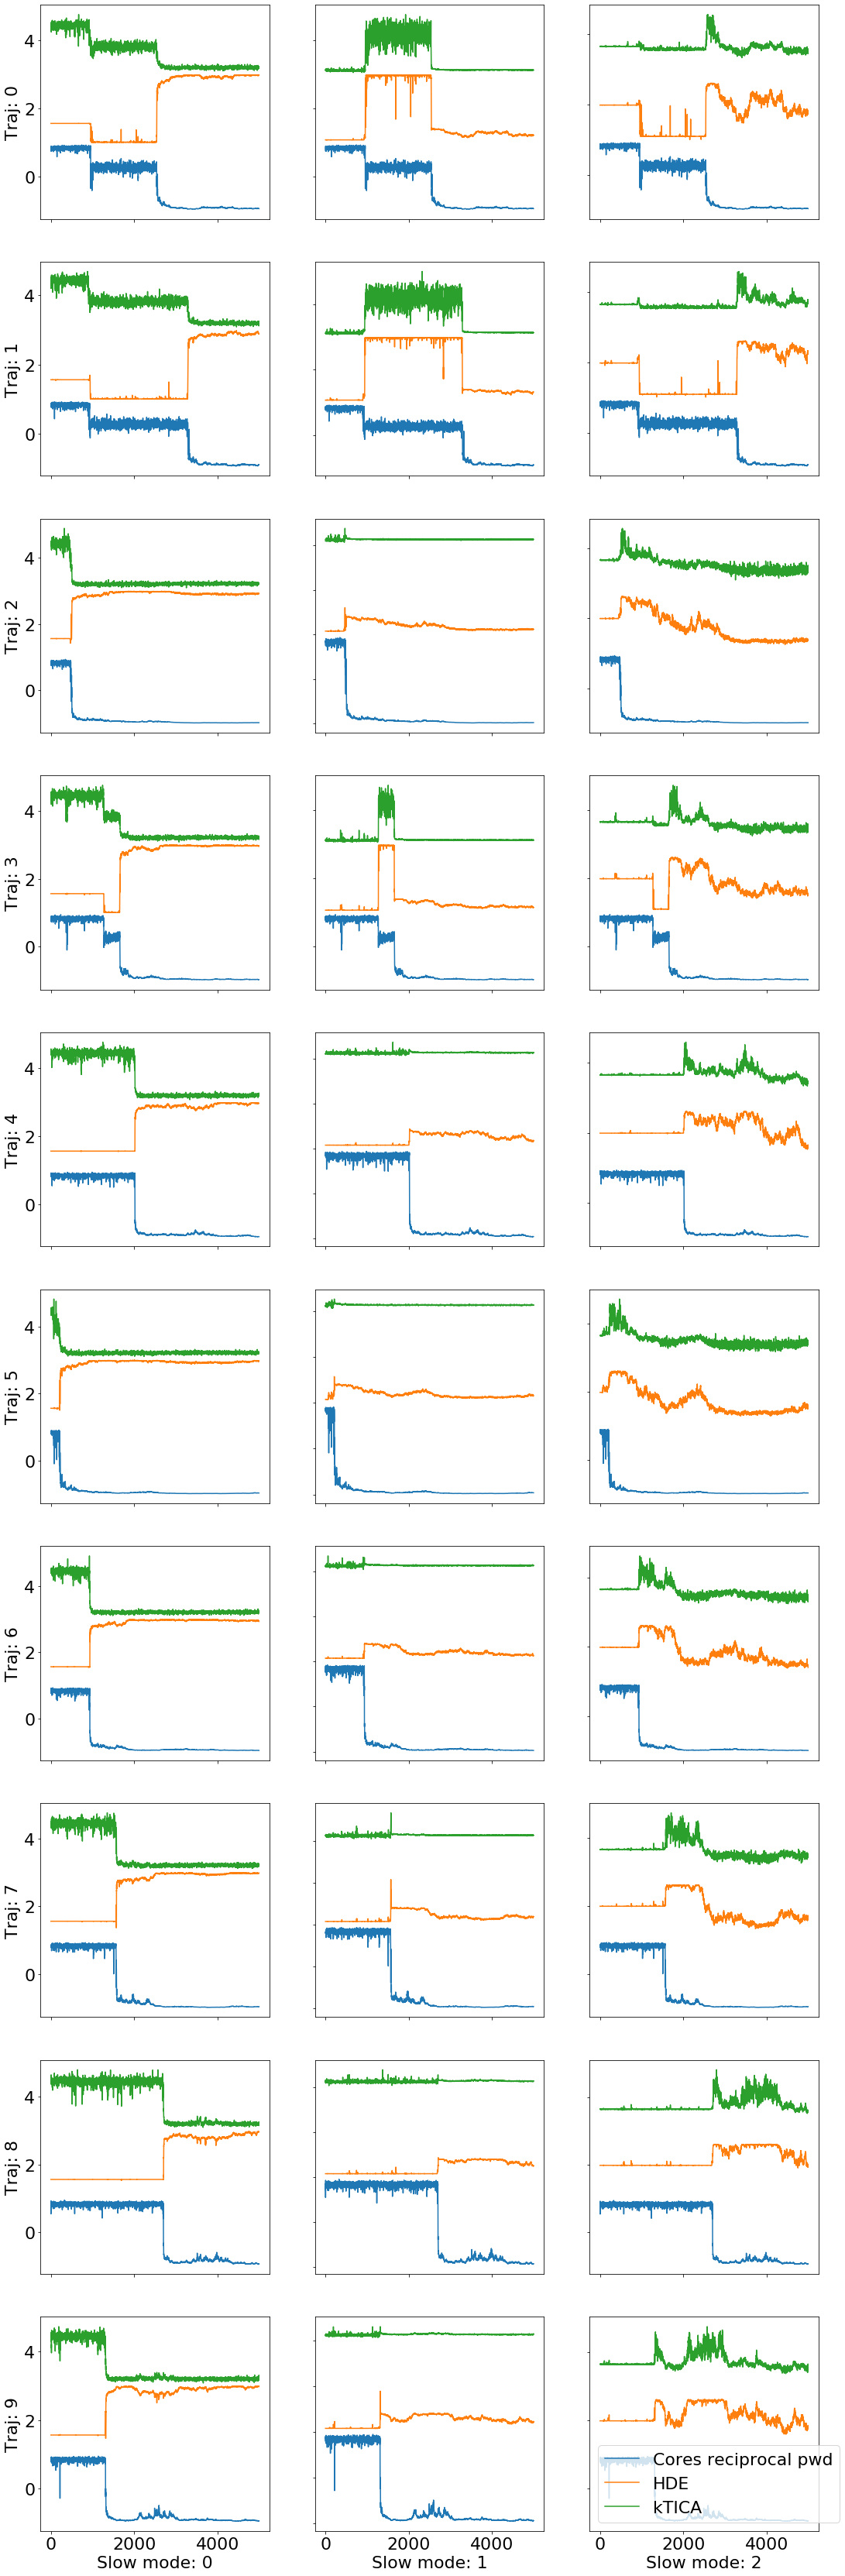

In [15]:
## grab specific indexed trajectories (with corresponding vmd snapshots) and plot with trained srv

## index of snapshot data
## need to make into subplots

#snapshot_list = [2, 5, 6]

snapshot_list = [i for i in range(10)]

scaler = pre.MinMaxScaler(feature_range=(-1, 1))
traj_num = len(pwd_features_s[0][:, 0])

pwd_snap = [pwd_features_s[i] for i in snapshot_list]

scaler.fit(np.concatenate(hde_coords))
hde_snap = [scaler.transform(hde_coords[i]) for i in snapshot_list]

scaler.fit(ktica_coords)
ktica_snap = [scaler.transform(ktica_coords[(traj_num*i):(traj_num*(i+1)), :]) for i in snapshot_list]

print (np.shape(pwd_snap))
print (np.shape(ktica_snap))
print (np.shape(hde_snap))

dim_x = len(ktica_snap[0][0, :])
dim_y = len(snapshot_list)
axes_labels = [0 for i in range(dim_x * dim_y)]

plt.rcParams.update({'font.size': 22})
tPlot, axes = plt.subplots(
        nrows=dim_y, ncols=dim_x, sharex=True, sharey=False, figsize=[6*dim_x, 6*dim_y],
        gridspec_kw={'wspace':0.2, 'hspace': 0.2}
        )

for i in range(dim_y):
    
    i_snap = snapshot_list[i]
    
    for j in range (0, dim_x):
        
        axes[i][j].plot((pwd_snap[i_snap][:, 45] + pwd_snap[i][:, 54]) / 2, label='Cores reciprocal pwd')
        axes[i][j].plot(hde_snap[i_snap][:, j] + 2, label='HDE')
        axes[i][j].plot(ktica_snap[i_snap][:, j] + 4, label='kTICA')
        axes_labels[i*dim_x+j] = ['Slow mode: ' + str(j), 'Traj: ' + str(i_snap)]
        
for i, ax in enumerate(axes.flat):
        ax.set(xlabel=axes_labels[i][0], ylabel=axes_labels[i][1])
        ax.label_outer()
        
ax.legend()
        
plt.show()


color =  inter_ends


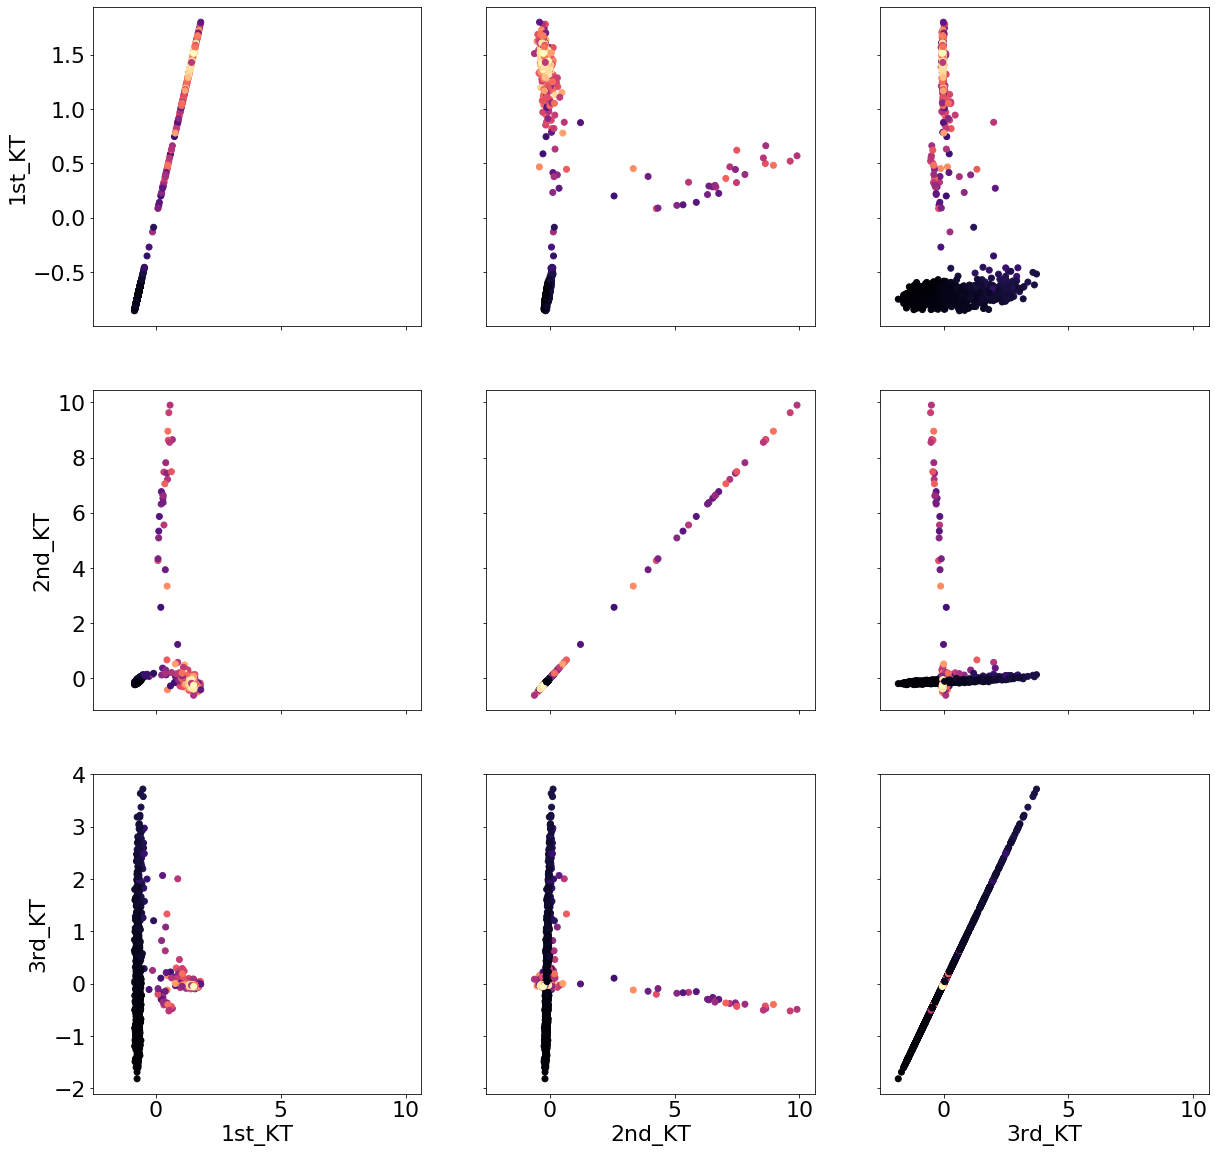

color =  inter_cores


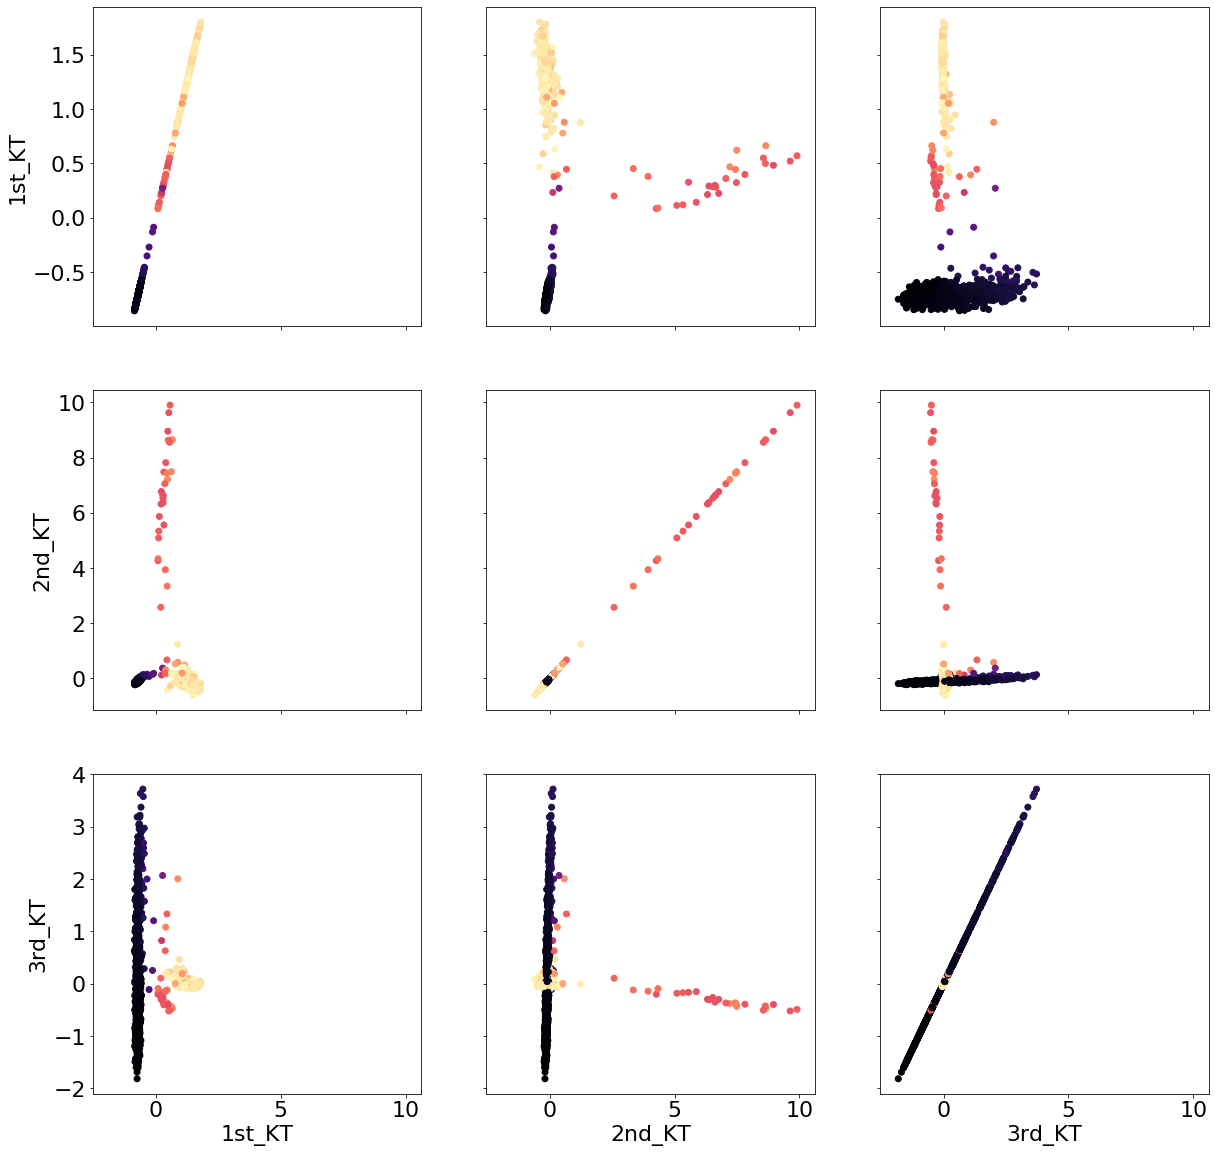

color =  inter_all


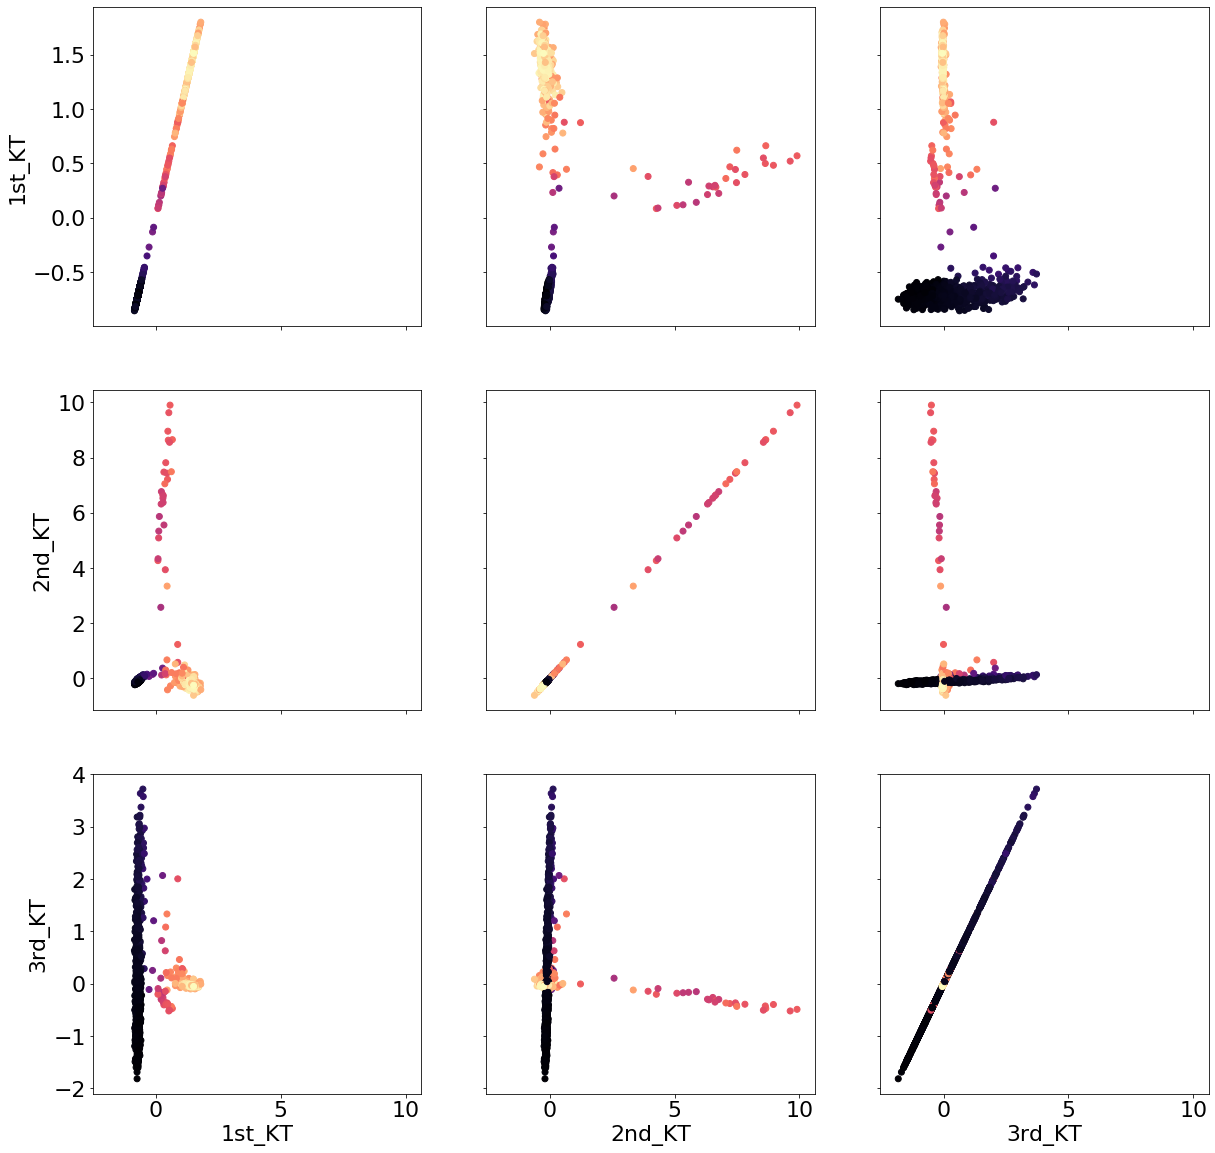

color =  intra_ends


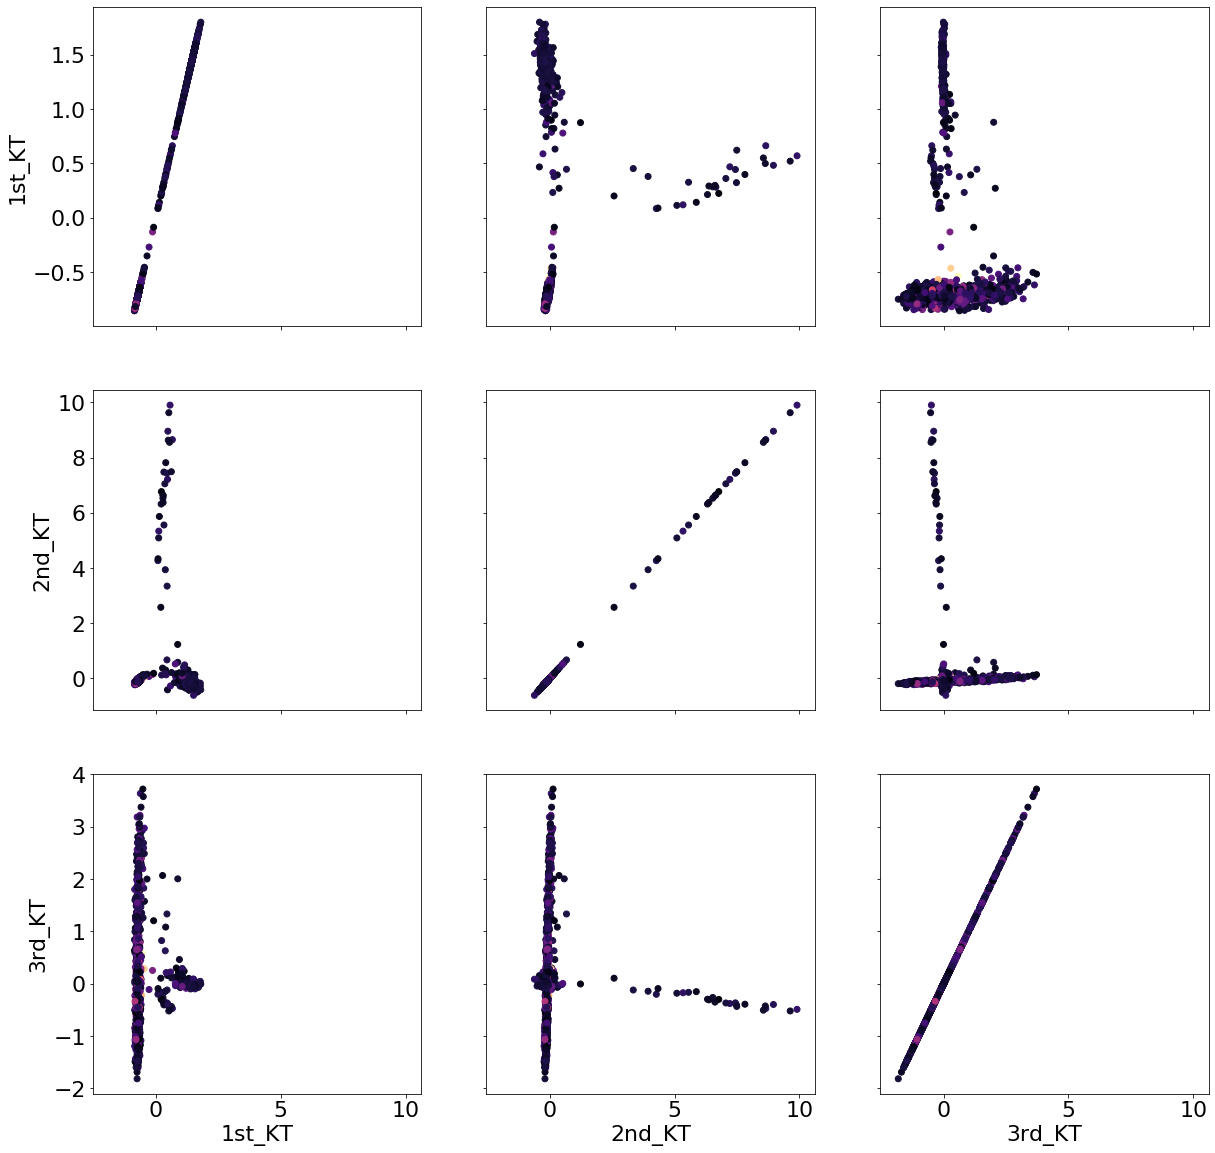

color =  intra_end_to_core


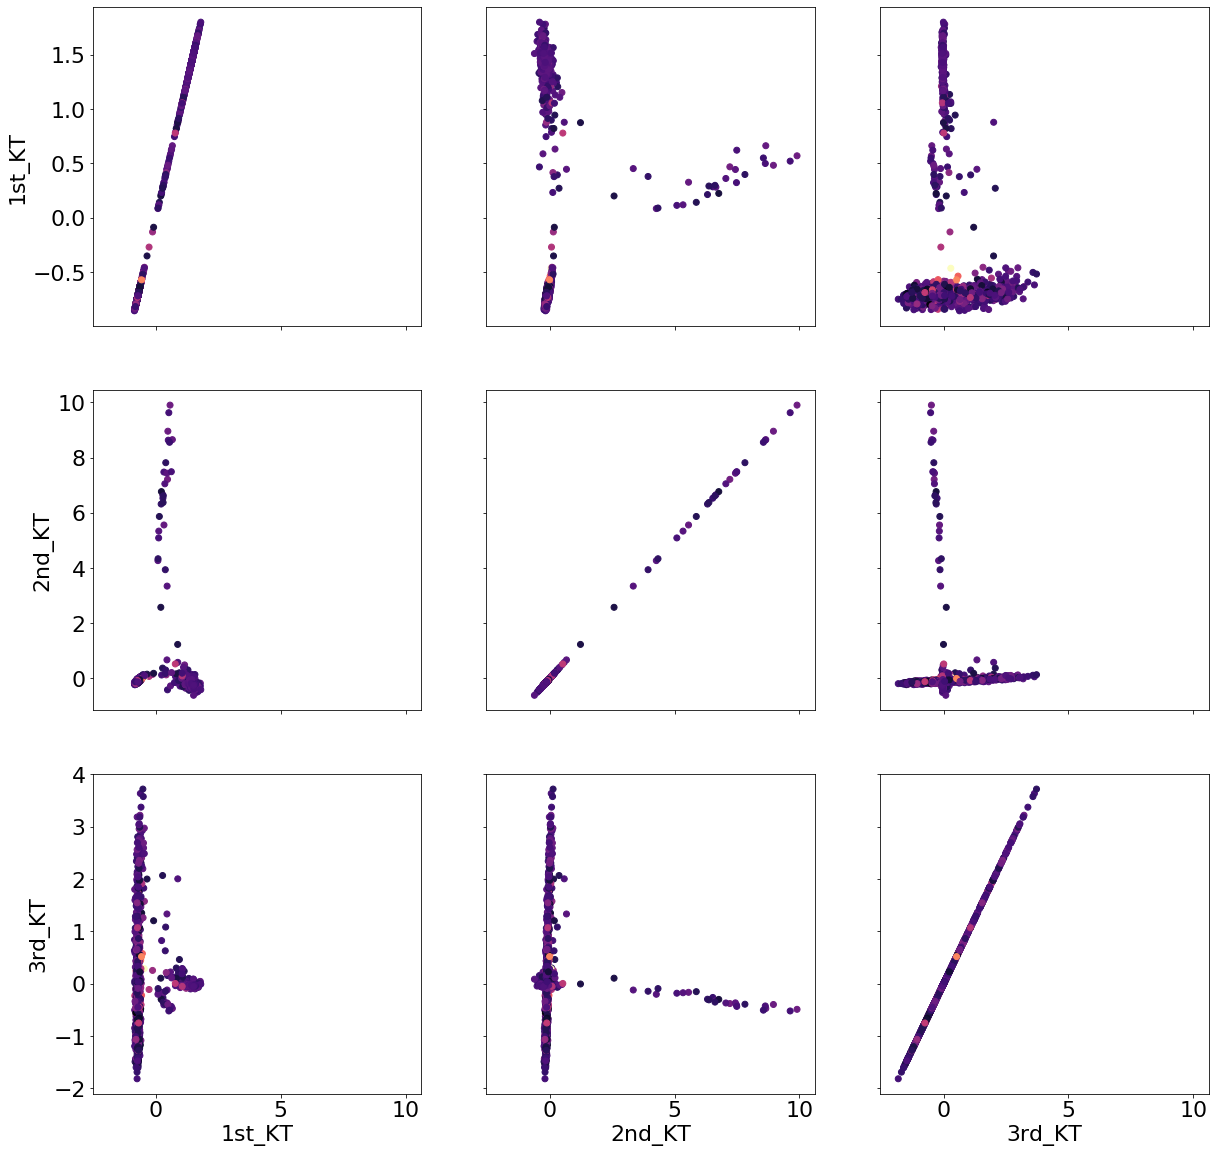

In [16]:
## maps all ktica coords against each other with physical features as the color map

for key in bp_match_dict:
    
    print('color = ', key)
    plot_ktica(df, ktica_list, key)

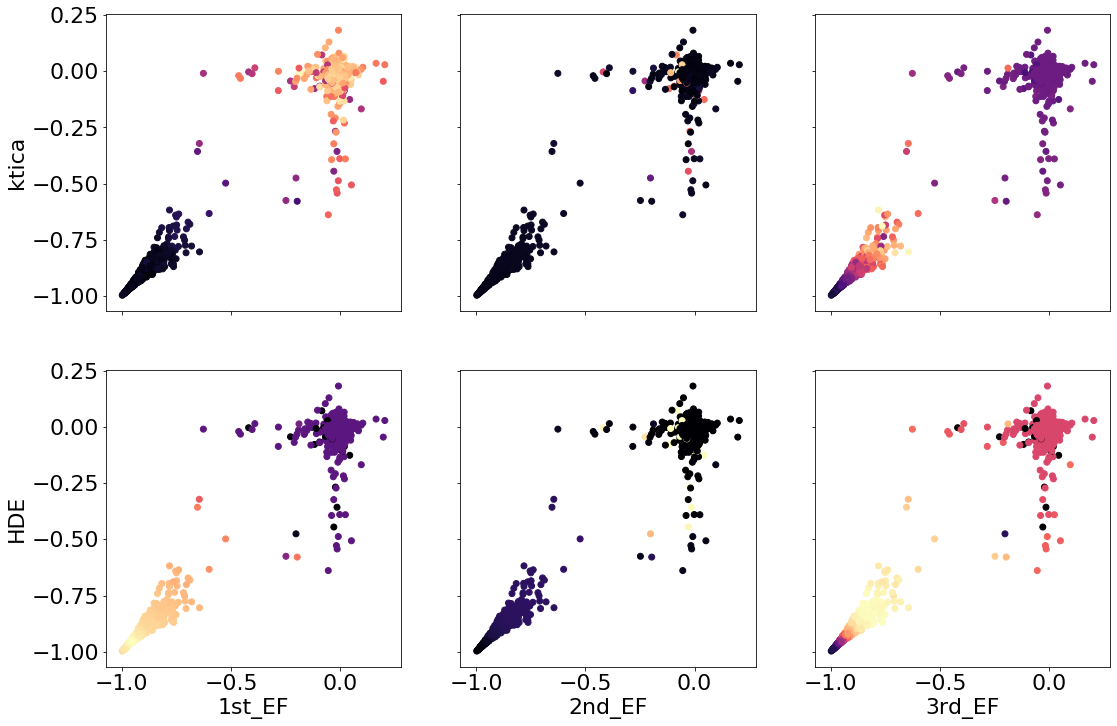

In [51]:
## print inter_all vs inter_core for first three ktica coords and HDE coords

plt.rcParams.update({'font.size': 22})

dim_x = 3
dim_y = 2

tPlot, axes = plt.subplots(
        nrows=dim_y, ncols=dim_x, sharex=True, sharey=False, figsize=[6*dim_x, 6*dim_y],
        gridspec_kw={'wspace':0.2, 'hspace': 0.2}
        )

axes_labels = [0 for i in range(dim_x * dim_y)]


#x = df['inter_all']
#y = df['inter_cores']
x = df['shift_4_up']
y = df['shift_4_down']

for i in range(dim_x):
    
    color_index = ktica_list[i]
    color = df[color_index]
    axes_labels[i] = ['ktica', color_index]
    
    axes[0][i].scatter(x, y, c=color, cmap='magma')

for i in range(dim_x):
    
    color_index = hde_col_list[i]
    color = df[color_index]
    axes_labels[i + 3] = ['HDE', color_index]
    
    axes[1][i].scatter(x, y, c=color, cmap='magma')


for i, ax in enumerate(axes.flat):
    ax.set(xlabel=axes_labels[i][1], ylabel=axes_labels[i][0])
    ax.label_outer()

plt.show()

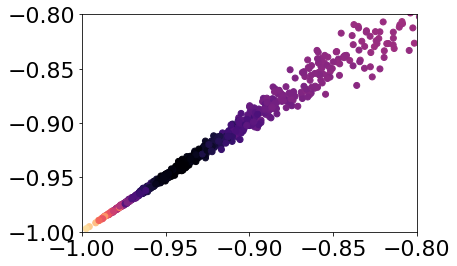

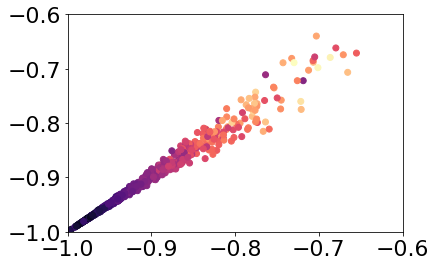

In [48]:
## Zoom in the lower left corner of thrid EF to better understand transition state


x = df['inter_all']
y = df['inter_cores']

color = df['5th_EF']

plt.scatter(x, y, c=color, cmap='magma')
plt.xlim(-1, -.6)
plt.ylim(-1, -.6)

plt.show()

x = df['inter_all']
y = df['inter_cores']

color = df['3rd_KT']

plt.scatter(x, y, c=color, cmap='magma')
plt.xlim(-1, -.6)
plt.ylim(-1, -.6)

plt.show()


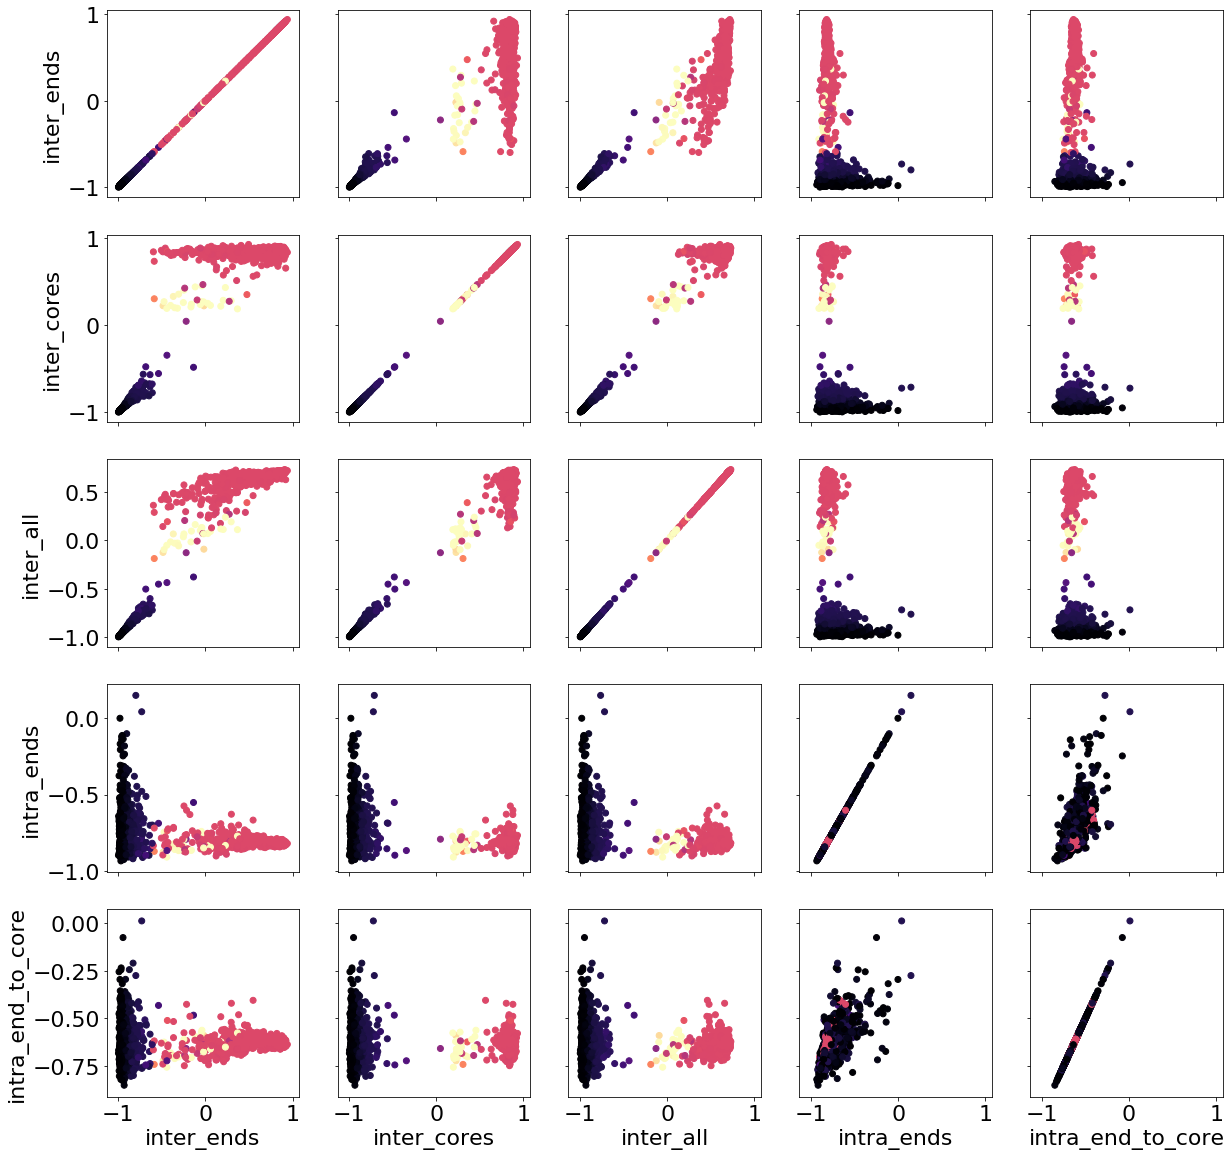

In [45]:
plot_subs(df, bp_match_dict, '1st_EF')

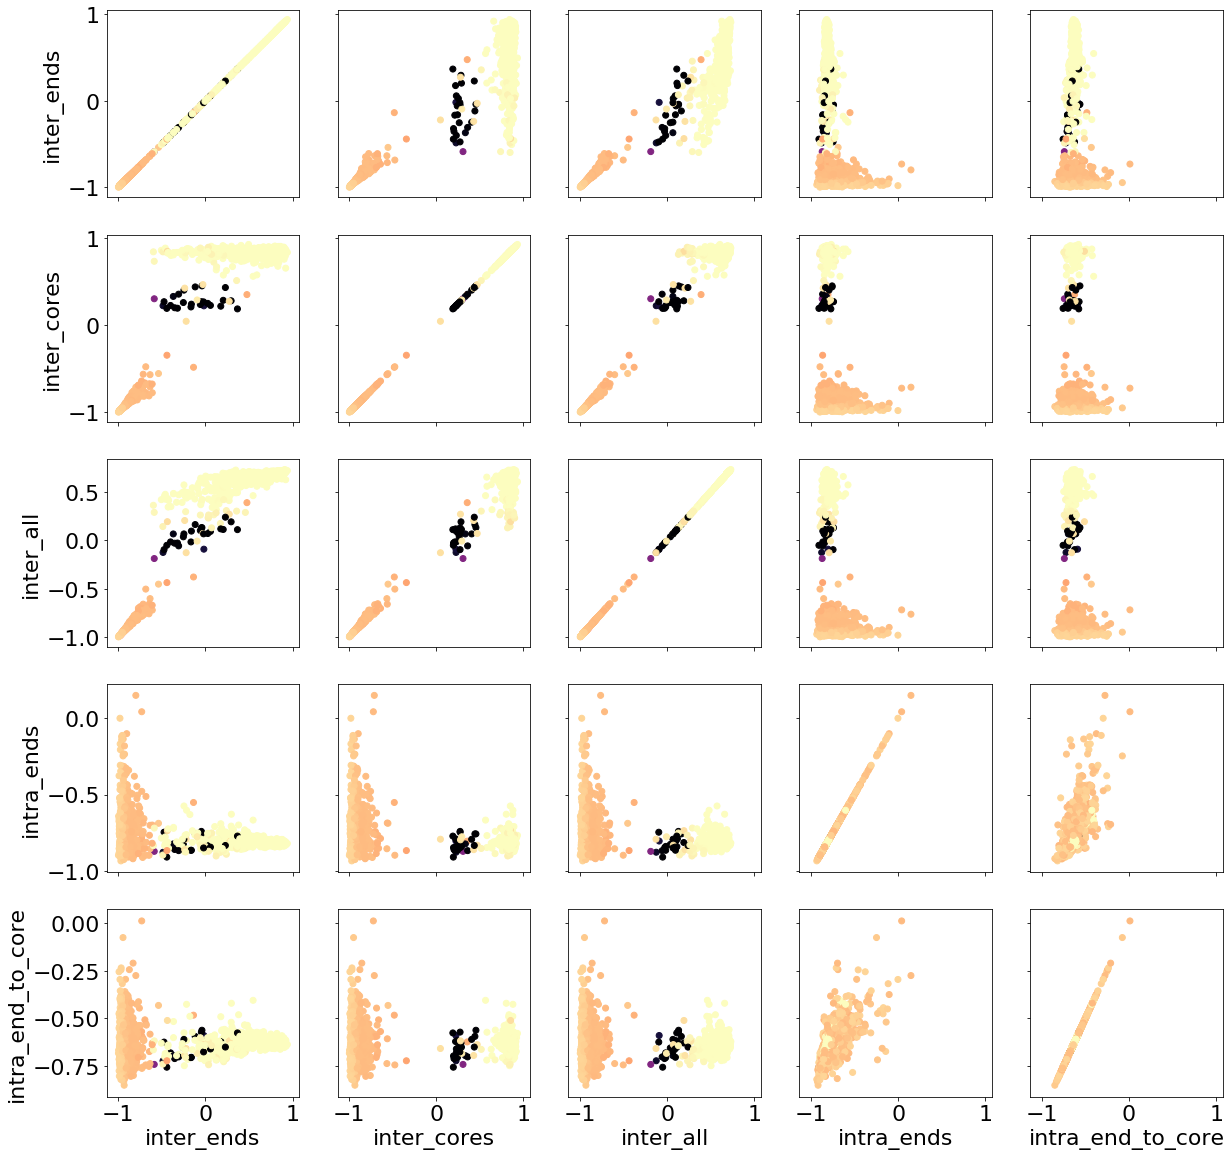

In [46]:
plot_subs(df, bp_match_dict, '2nd_EF')

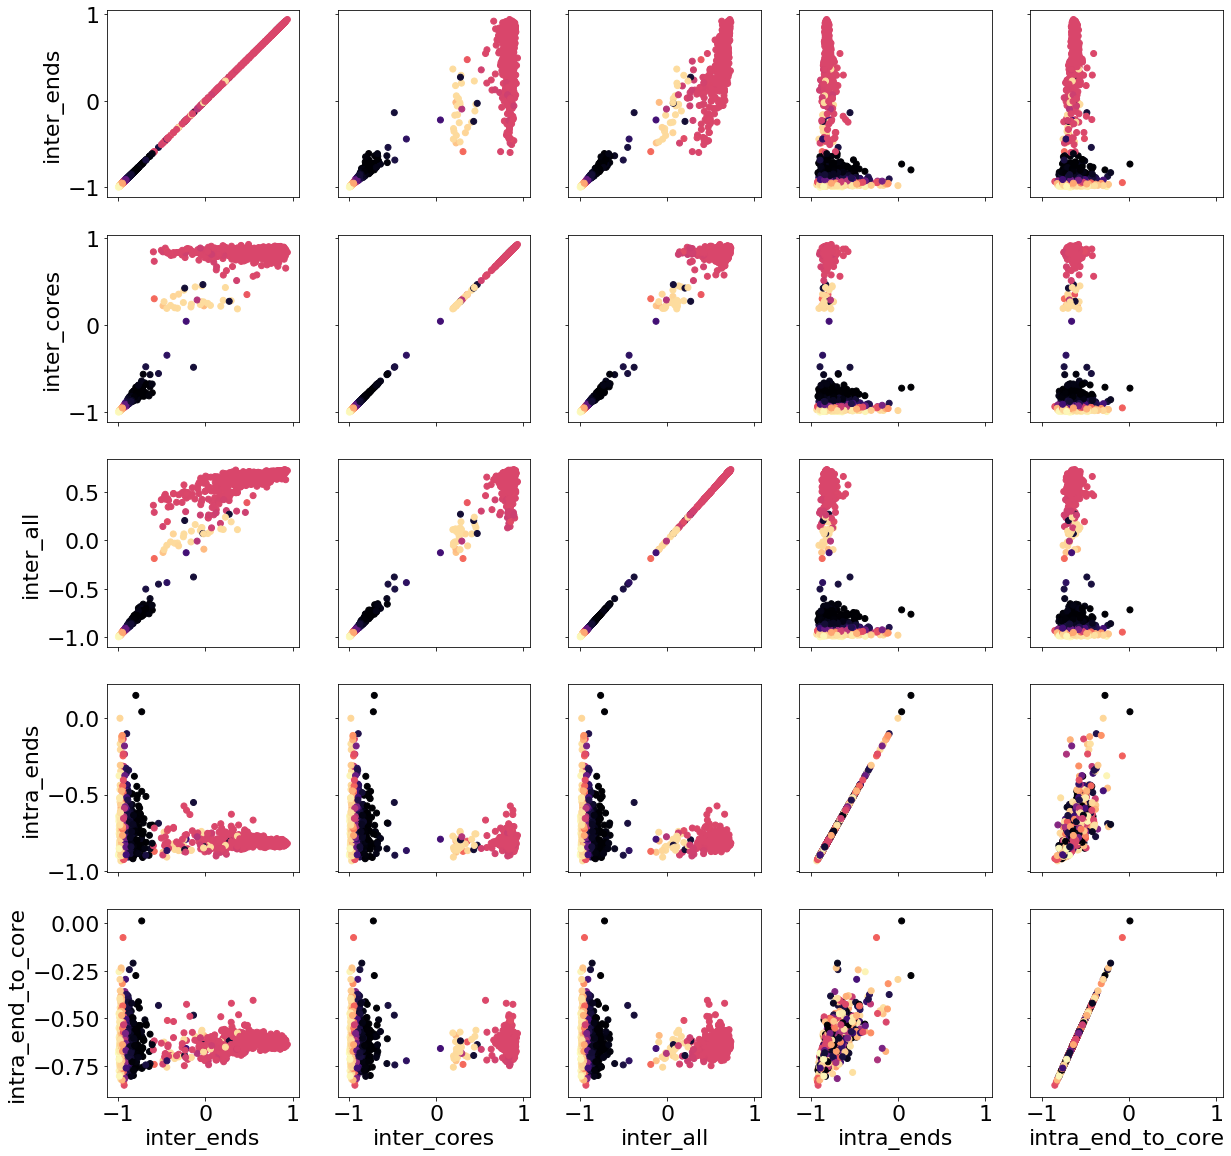

In [47]:
plot_subs(df, bp_match_dict, '3rd_EF')

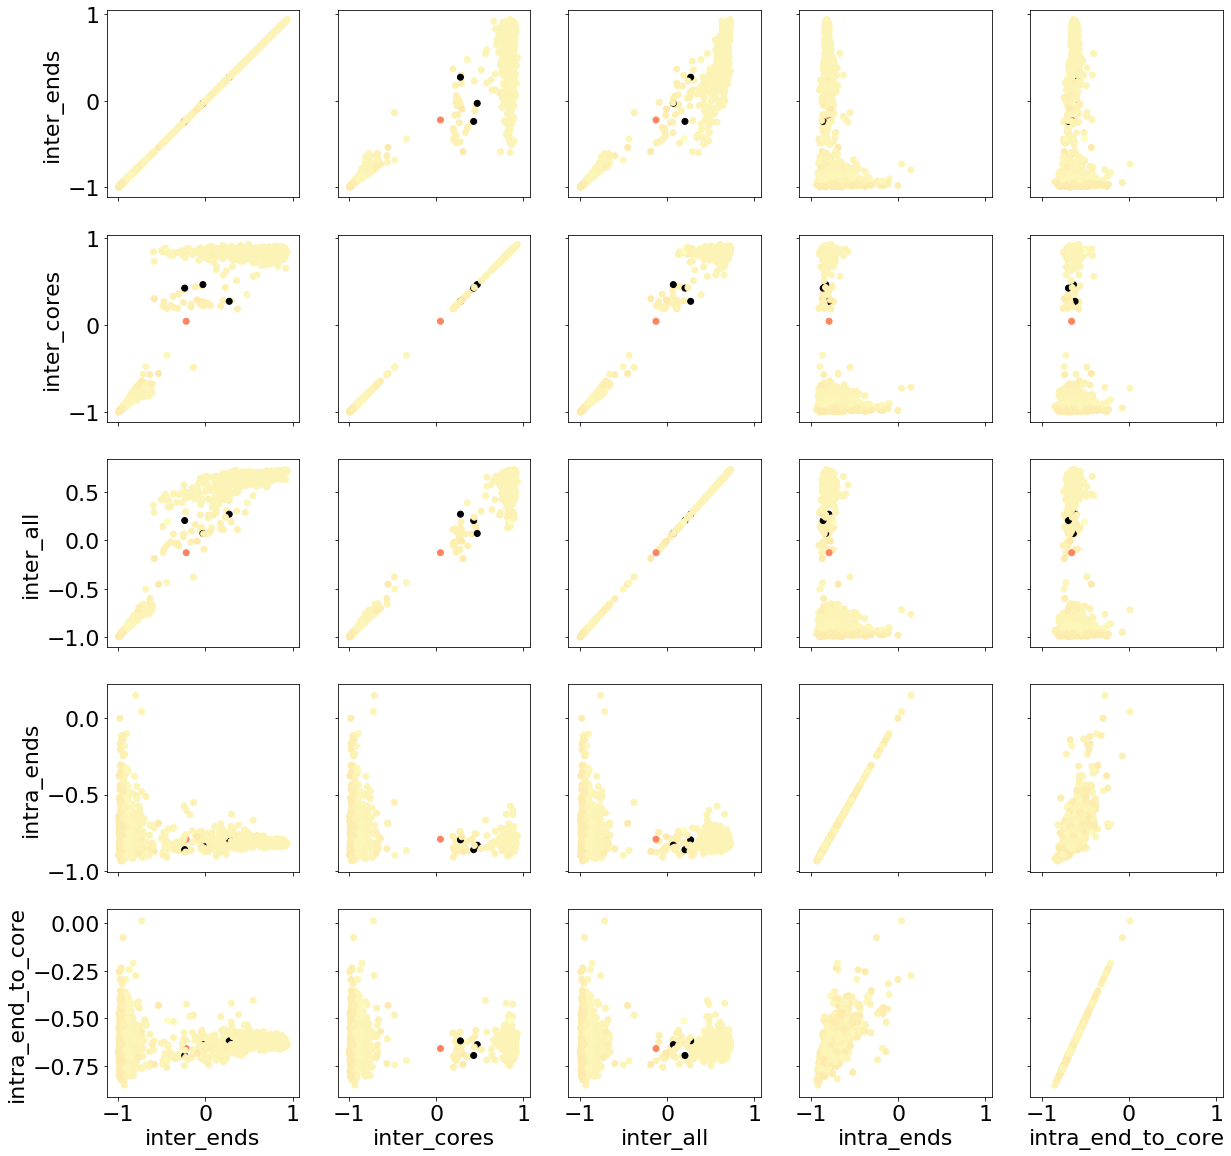

In [48]:
plot_subs(df, bp_match_dict, '4th_EF')

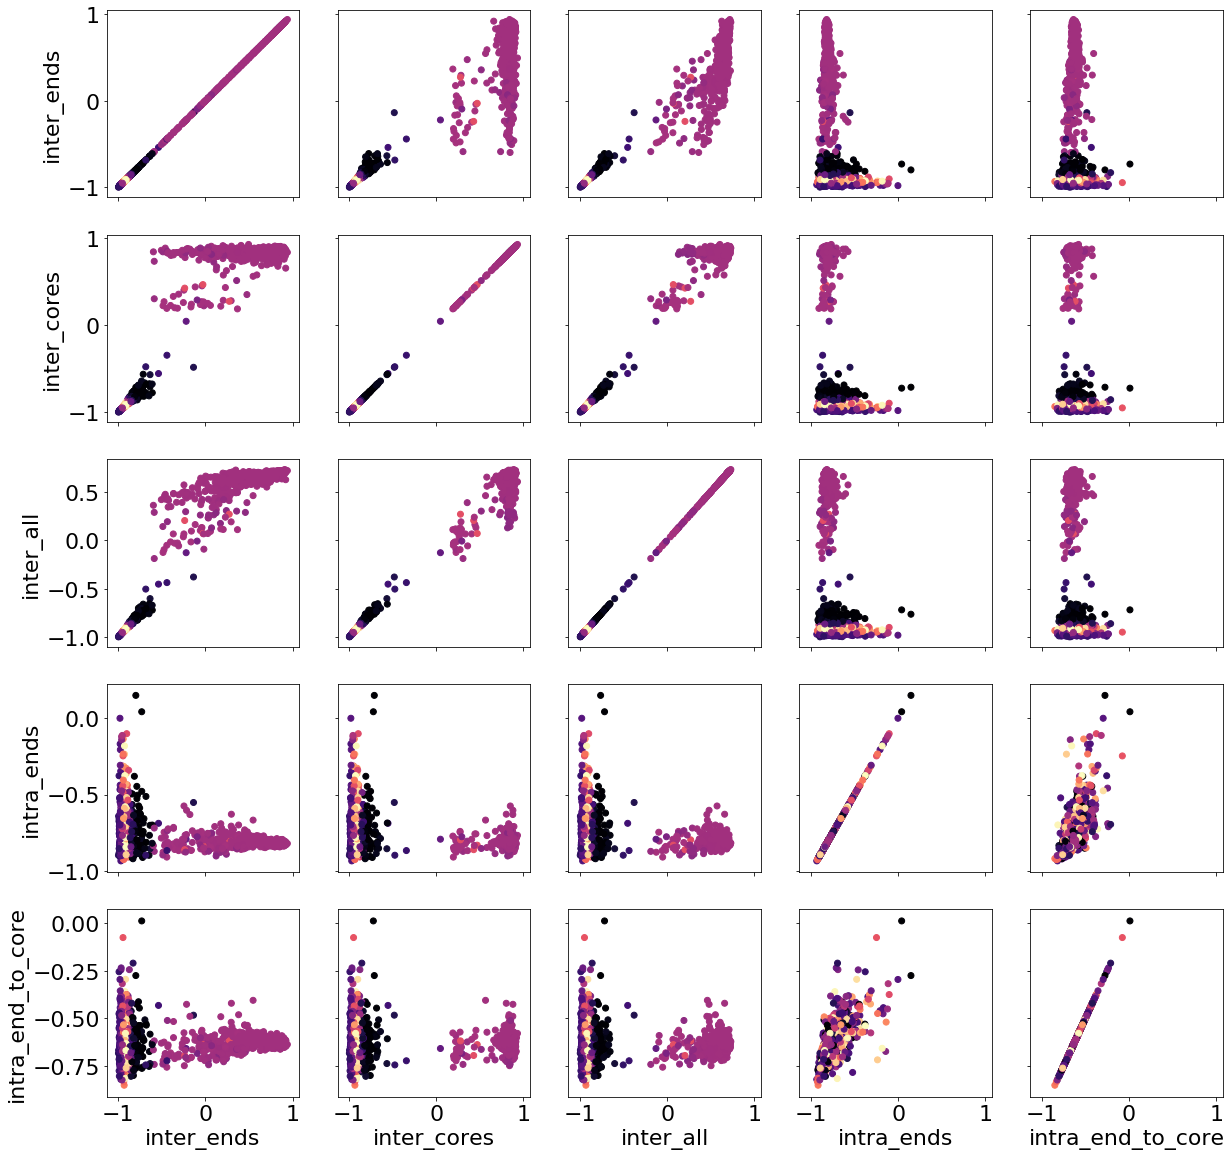

In [49]:
plot_subs(df, bp_match_dict, '5th_EF')

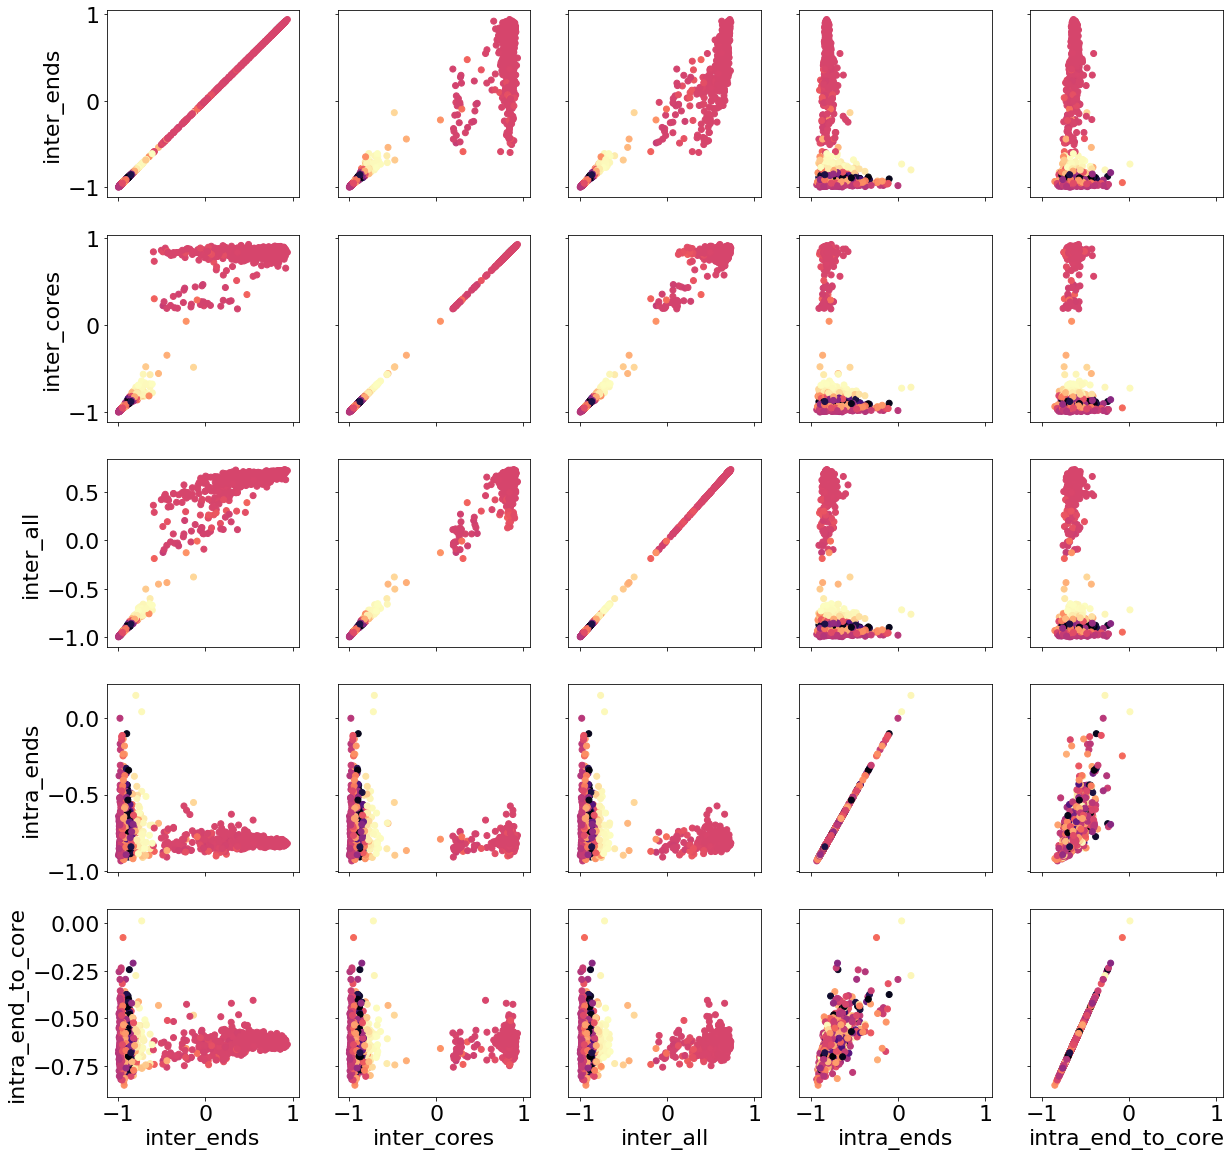

In [50]:
plot_subs(df, bp_match_dict, '6th_EF')

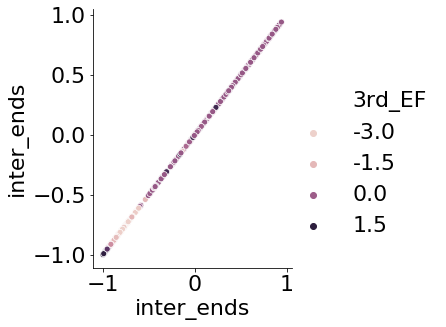

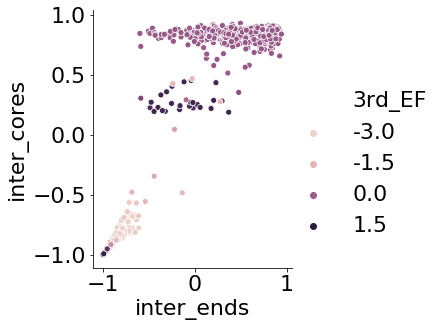

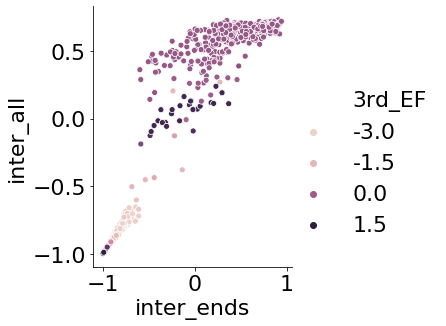

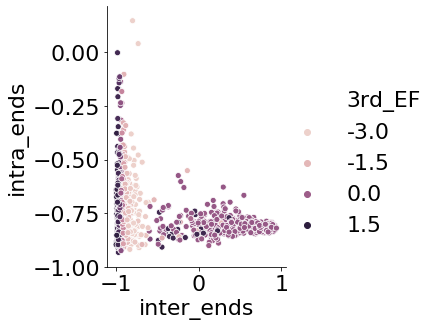

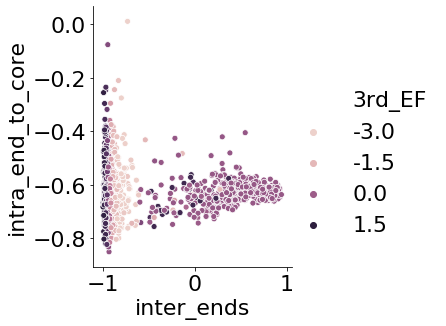

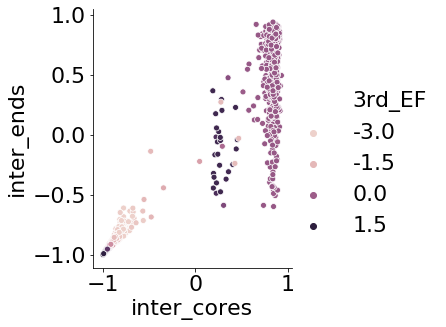

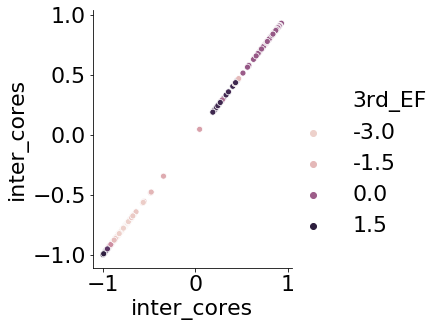

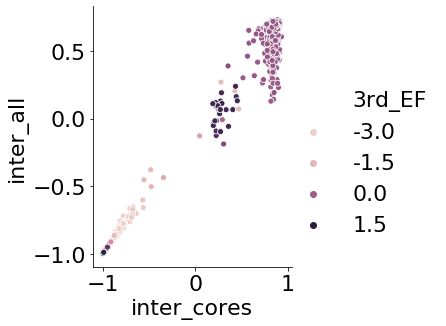

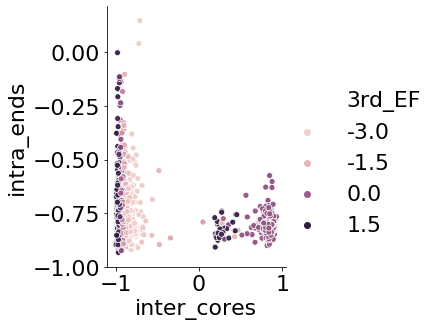

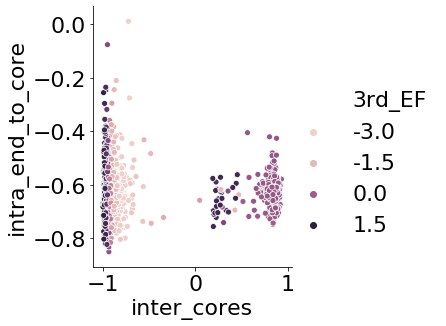

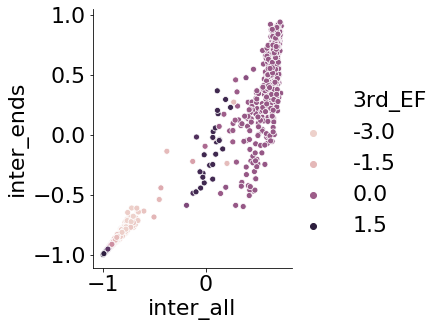

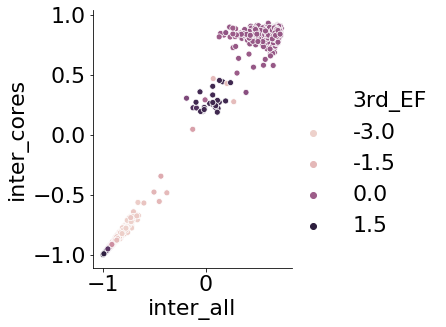

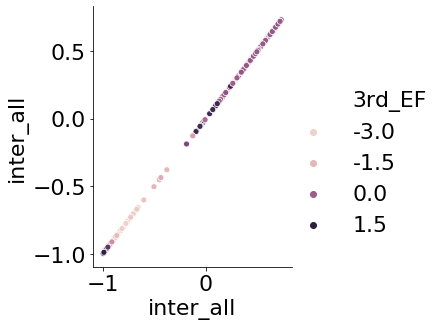

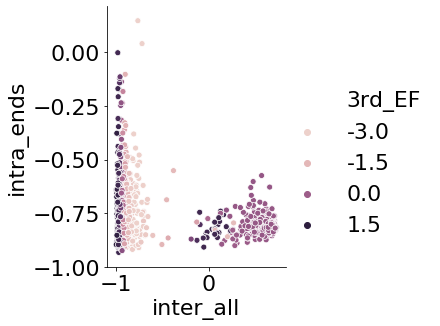

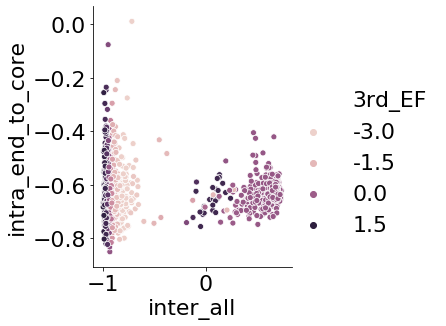

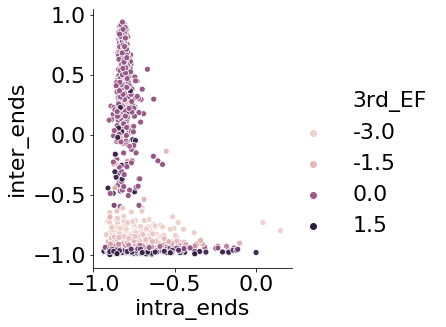

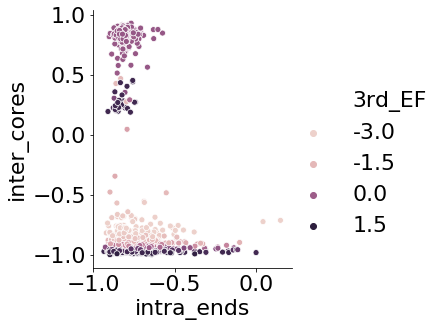

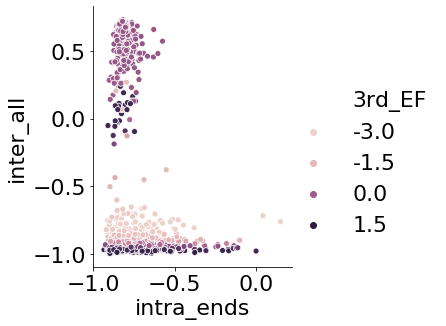

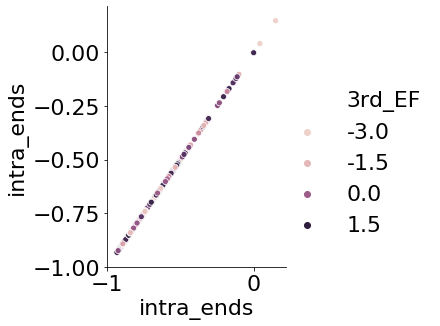

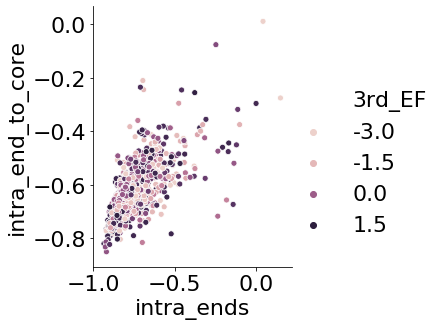

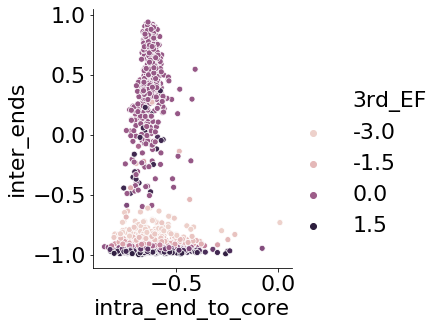

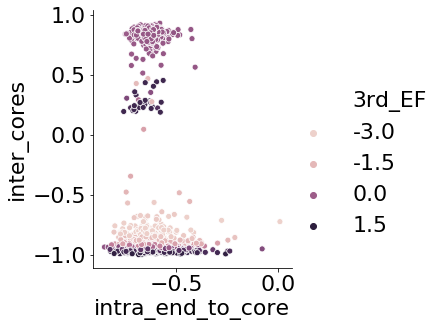

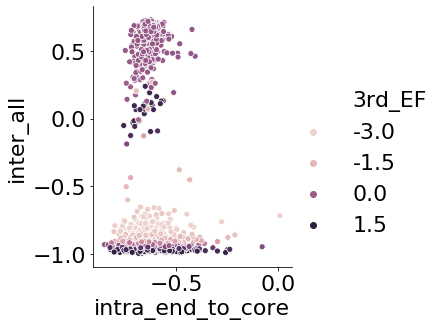

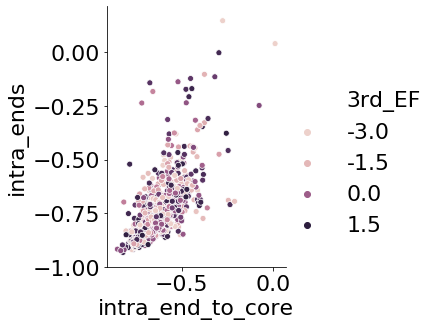

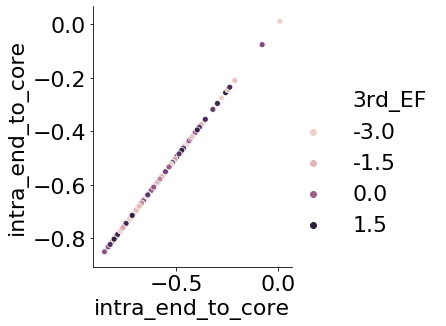

In [51]:
for k_i in bp_match_dict:
    for k_j in bp_match_dict:
        
        sns.relplot(data = df,
                    x = k_i, 
                    y = k_j, 
                    hue = "3rd_EF",
                    )